# CSE 311A Programming Assignment 2 - David Frankel (466602)

In [1]:
import random
import copy
from itertools import islice
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# True: Cooperate, False: Defect

# Tit-for-Tat (T4T) players
# Start by cooperating and play the opponent’s last action in subsequent rounds
class T4T:
    payoff = 0
    og_choice = True
    choice = True # Defaults to cooperating, should change to opponent's last action
    def update(self, opponent_choice):
        self.choice = opponent_choice
    def reset(self):
        self.choice = self.og_choice
    def fullreset(self):
        self.choice = self.og_choice
        self.payoff = 0
        
# Grudger (G) players
# Cooperate until the opponent defects, after which it only defects
class G:
    payoff = 0
    og_choice = True
    choice = True # Defaults to cooperating, should change to defection as response
    def update(self, opponent_choice):
        if not opponent_choice:
            self.choice = False
    def reset(self):
        self.choice = self.og_choice
    def fullreset(self):
        self.choice = self.og_choice
        self.payoff = 0
        
# Always Cooperate (AC) players
# Always cooperate
class AC:
    payoff = 0
    og_choice = True
    choice = True
    def update(self, opponent_choice):
        pass
    def reset(self):
        self.choice = self.og_choice
    def fullreset(self):
        self.choice = self.og_choice
        self.payoff = 0
        
# Always Defect (AD) players
# Always defect
class AD:
    payoff = 0
    og_choice = False
    choice = False
    def update(self, opponent_choice):
        pass
    def reset(self):
        self.choice = self.og_choice
    def fullreset(self):
        self.choice = self.og_choice
        self.payoff = 0
        
        

In [12]:
def simulate_generation(players, m):
    # Players needs to be an input list of already made player objects
    already_visited = 0
    for one in players:
        already_visited += 1
        for two in islice(players, already_visited, None):
            for _ in range(m):
                if one.choice and two.choice:
                    one.payoff += 3
                    two.payoff += 3
                elif not one.choice and not two.choice:
                    one.payoff += 1
                    two.payoff += 1
                elif one.choice:
                    two.payoff += 5
                elif two.choice:
                    one.payoff += 5
                else:
                    print("Never be here!")

                one_choice = one.choice
                two_choice = two.choice
                one.update(two_choice)
                two.update(one_choice)

            # Resets player state between games
            one.reset()
            two.reset()

def birth(players, m, p, k, printing=True):
    reset_global_stats()
    p = p / 100
    generation = players
    for i in range(k):
        simulate_generation(generation, m)
        if printing:
            print("Gen ", (i+1),": ", sep="", end="")
        print_stats(generation, printing)
        
        random.shuffle(generation) # Allows easy tie-breaking
        generation.sort(key=lambda x: x.payoff)
        p_num_players = int(len(generation) // (1/p))
        del generation[:p_num_players]
        new_players = []
        for new in generation[-p_num_players:]:
            new_players.append(type(new)())
        generation = generation + new_players
        for player in generation:
            player.fullreset()
        

In [13]:
stackplot_type_percentage = [[], [], [], []]
stackplot_type_total = [[], [], [], []]
multiline_type_avg = [[], [], [], []]
unknown_type_payoff_total = []

def reset_global_stats():
    # Access to globals
    global stackplot_type_percentage
    global stackplot_type_total
    global multiline_type_avg
    global unknown_type_payoff_total
    stackplot_type_percentage = [[], [], [], []]
    stackplot_type_total = [[], [], [], []]
    multiline_type_avg = [[], [], [], []]
    unknown_type_payoff_total = []

def print_stats(players, printing):
    # Access to globals
    global stackplot_type_percentage
    global stackplot_type_total
    global multiline_type_avg
    global unknown_type_payoff_total
    
    # Always in T4T, G, AC, AD order
    n = len(players)
    player_types = ['T4T', 'G', 'AC', 'AD']
    player_types_num = np.array([0, 0, 0, 0])
    player_types_payoff = np.array([0, 0, 0, 0])
    for player in players:
        if type(player) is T4T:
            player_types_num[0] += 1
            player_types_payoff[0] += player.payoff
        elif type(player) is G:
            player_types_num[1] += 1
            player_types_payoff[1] += player.payoff
        elif type(player) is AC:
            player_types_num[2] += 1
            player_types_payoff[2] += player.payoff
        elif type(player) is AD:
            player_types_num[3] += 1
            player_types_payoff[3] += player.payoff
        else:
            print("Nope! Not here")
    
    player_types_num = (player_types_num * 100) // n
    
    if printing:
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_num[i], "%  ", sep="", end="")
        print()


        print("       ", end="")
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_payoff[i], "  ", sep="", end="")
        print("Total: ", sum(player_types_payoff), end="")
        print()
        print("       ", end="")
    
    for i in range(4):
        stackplot_type_percentage[i].append(player_types_num[i])
        stackplot_type_total[i].append(player_types_payoff[i])
    unknown_type_payoff_total.append(sum(player_types_payoff))
    
    
    with np.errstate(invalid='ignore', divide='ignore'):
        # player_types_payoff = np.nan_to_num(player_types_payoff / player_types_num)
        # Corrects graphing issue
        player_types_payoff = (player_types_payoff / player_types_num)

    for i in range(4):
        multiline_type_avg[i].append(player_types_payoff[i])
        
    if printing:
        for i in range(len(player_types)):
            print(player_types[i], ": ", player_types_payoff[i], "  ", sep="", end="")
        print()


In [14]:
def gen_n_player_evenly(n):
    players = []
    for _ in range(n // 4):
        players.append(T4T())
        players.append(G())
        players.append(AC())
        players.append(AD())
    return players
    

In [15]:
def plot_globals():    
    # Plot percentage of population by type.
    labels = ['T4T', 'G', 'AC', 'AD']
    
    _, ax = plt.subplots()
    x_axis_vals = np.arange(1, len(stackplot_type_percentage[0])+1)
    x_axis_ticks = np.arange(1, len(stackplot_type_percentage[0])+1, step=(len(stackplot_type_percentage[0])+1) // 10)
    ax.stackplot(x_axis_vals, stackplot_type_percentage, labels=labels)
    ax.legend(loc='upper right')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Percentage')
    ax.set_title('Population by Type')
    ax.set_xticks(x_axis_ticks)
    plt.show()
    #     plt.clf()
    
    _, ax = plt.subplots()
    ax.stackplot(np.arange(1, len(stackplot_type_percentage[0])+1), stackplot_type_total, labels=labels)
    ax.legend(loc='upper right')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Payoff')
    ax.set_title('Payoff by Type and Total Payoff')
    ax.set_xticks(x_axis_ticks)
    plt.plot()
    plt.show()
    
    plt.clf()
    
    plt.title("Average Payoff by Type")
    plt.xlabel("Generation")
    plt.ylabel("Average Payoff")
    line_type = ['-', '--', ':', '-.']
    for i in range(len(multiline_type_avg)):
        plt.plot(multiline_type_avg[i], line_type[i], label=labels[i])
    plt.legend(loc="upper right")
    plt.show()



## Question 1

In [16]:
# Running the program with specified parameters

n = 100 # Starting num of players
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations
players = gen_n_player_evenly(n)
birth(players, m, p, k)

Gen 1: T4T: 25%  G: 25%  AC: 25%  AD: 25%  
       T4T: 30250  G: 30250  AC: 27750  AD: 29875  Total:  118125
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1195.0  
Gen 2: T4T: 26%  G: 29%  AC: 20%  AD: 25%  
       T4T: 31460  G: 35090  AC: 22200  AD: 27875  Total:  116625
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1115.0  
Gen 3: T4T: 28%  G: 32%  AC: 15%  AD: 25%  
       T4T: 33880  G: 38720  AC: 16650  AD: 25875  Total:  115125
       T4T: 1210.0  G: 1210.0  AC: 1110.0  AD: 1035.0  
Gen 4: T4T: 31%  G: 34%  AC: 15%  AD: 20%  
       T4T: 39215  G: 43010  AC: 17775  AD: 21100  Total:  121100
       T4T: 1265.0  G: 1265.0  AC: 1185.0  AD: 1055.0  
Gen 5: T4T: 34%  G: 36%  AC: 15%  AD: 15%  
       T4T: 44880  G: 47520  AC: 18900  AD: 16125  Total:  127425
       T4T: 1320.0  G: 1320.0  AC: 1260.0  AD: 1075.0  
Gen 6: T4T: 35%  G: 40%  AC: 15%  AD: 10%  
       T4T: 48125  G: 55000  AC: 20025  AD: 10950  Total:  134100
       T4T: 1375.0  G: 1375.0  AC: 1335.0  AD: 1095.0  
Gen 

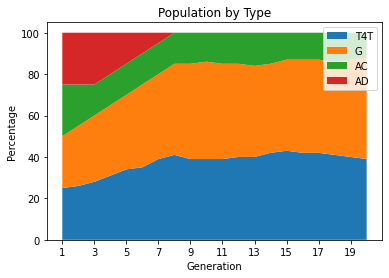

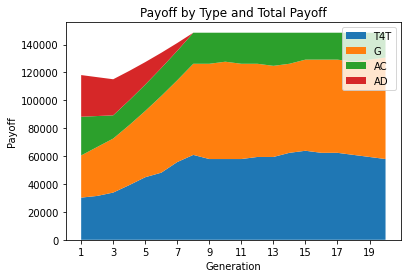

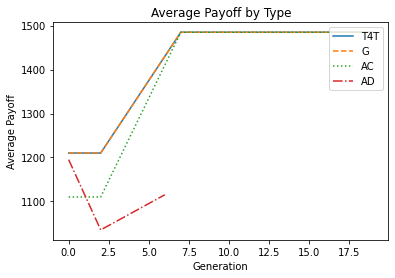

In [17]:
# Generating plots

plot_globals()

Looking at the plots above, I noticed the following trends:

- Players of the type AD are driven to extinction. This could be because 

- Average payoffs increase to the same level then plateau for all players types except AD. In addition, overall payoff total and generation change stagnates. This could be because

## Question 2

### First Distribution: One Grudger player, one Always Cooperate player, and n-2 Tit-for-Tat players

Gen 1: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 2: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 3: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 4: T4T: 98%  G: 1%  AC: 1%  AD: 0%  
       T4T: 145530  G: 1485  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: 1485.0  AC: 1485.0  AD: nan  
Gen 5: T4T: 99%  G: 0%  AC: 1%  AD: 0%  
       T4T: 147015  G: 0  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: nan  AC: 1485.0  AD: nan  
Gen 6: T4T: 99%  G: 0%  AC: 1%  AD: 0%  
       T4T: 147015  G: 0  AC: 1485  AD: 0  Total:  148500
       T4T: 1485.0  G: nan  AC: 1485.0  AD: nan  
Gen 7: T4T: 99%  G: 0%  AC: 1%  AD: 0%  
       T4T: 147015  G: 0  AC: 1485  AD: 0

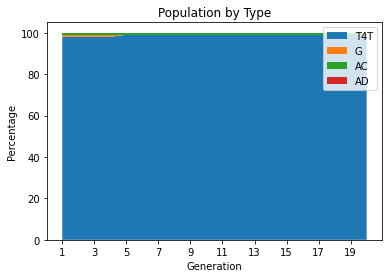

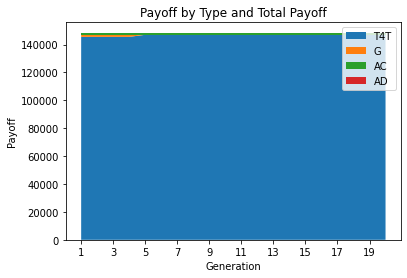

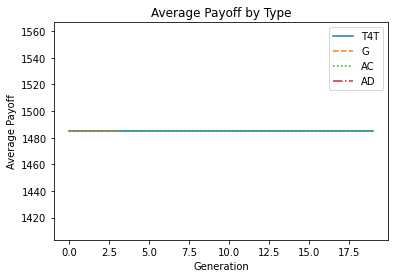

In [18]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = [G(), AC()]
for _ in range(n-len(players)):
    players.append(T4T())

birth(players, m, p, k)
plot_globals()

Looking at the plots above, I noticed the following trends:

- Stagnating from first generation becuase all have the same average payoff. Since no player ever defects, they all have the payoff. This is essentially what happens after a few generations in the first question's setup.

### Second Distribution: One Grudger player, one Always Cooperate player, and n-2 Always Defect players

Gen 1: T4T: 0%  G: 1%  AC: 1%  AD: 98%  
       T4T: 0  G: 407  AC: 15  AD: 50862  Total:  51284
       T4T: nan  G: 407.0  AC: 15.0  AD: 519.0  
Gen 2: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 3: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 4: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 5: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 6: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 7: T4T: 0%  G: 0%  AC: 0%  AD: 100%  
       T4T: 0  G: 0  AC: 0  AD: 49500  Total:  49500
       T4T: nan  G: nan  AC: nan  AD: 495.0  
Gen 8: T

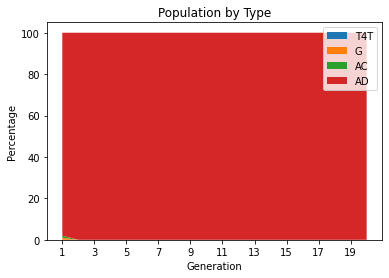

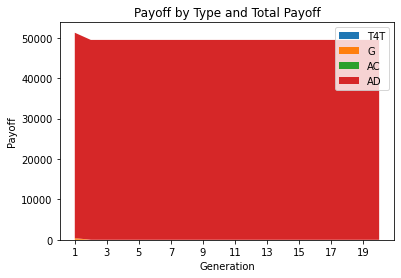

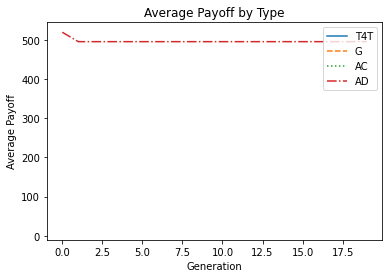

In [19]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = [G(), AC()]
for _ in range(n-len(players)):
    players.append(AD())

birth(players, m, p, k)
plot_globals()

Looking at the plots above, I noticed the following trends:

- AHHHHH

### Third Distribution: Mostly AD, with some G, and very little AC and tiny amount of T4T

Gen 1: T4T: 2%  G: 20%  AC: 8%  AD: 70%  
       T4T: 1430  G: 14300  AC: 3480  AD: 52010  Total:  71220
       T4T: 715.0  G: 715.0  AC: 435.0  AD: 743.0  
Gen 2: T4T: 2%  G: 20%  AC: 3%  AD: 75%  
       T4T: 1320  G: 13200  AC: 1080  AD: 48225  Total:  63825
       T4T: 660.0  G: 660.0  AC: 360.0  AD: 643.0  
Gen 3: T4T: 3%  G: 24%  AC: 0%  AD: 73%  
       T4T: 2046  G: 16368  AC: 0  AD: 44019  Total:  62433
       T4T: 682.0  G: 682.0  AC: nan  AD: 603.0  
Gen 4: T4T: 4%  G: 28%  AC: 0%  AD: 68%  
       T4T: 2948  G: 20636  AC: 0  AD: 42364  Total:  65948
       T4T: 737.0  G: 737.0  AC: nan  AD: 623.0  
Gen 5: T4T: 4%  G: 33%  AC: 0%  AD: 63%  
       T4T: 3168  G: 26136  AC: 0  AD: 40509  Total:  69813
       T4T: 792.0  G: 792.0  AC: nan  AD: 643.0  
Gen 6: T4T: 4%  G: 38%  AC: 0%  AD: 58%  
       T4T: 3388  G: 32186  AC: 0  AD: 38454  Total:  74028
       T4T: 847.0  G: 847.0  AC: nan  AD: 663.0  
Gen 7: T4T: 5%  G: 42%  AC: 0%  AD: 53%  
       T4T: 4510  G: 37884  AC: 0  A

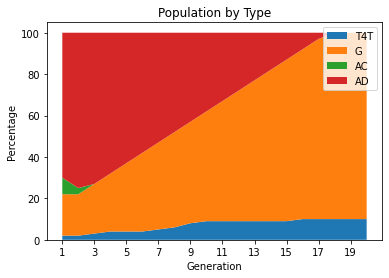

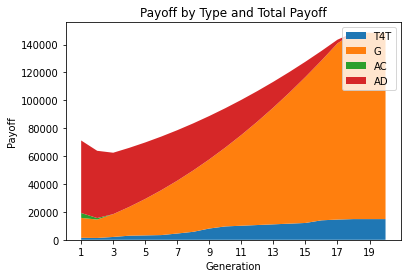

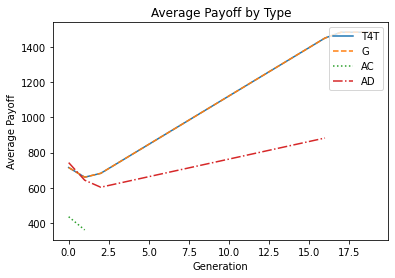

In [20]:
# Running the program with specified parameters
n = 100
m = 5 # Rounds between players
p = 5 # Pruning between generations
k = 20 # Generations

# Manually creating distributions
players = []
for _ in range(8):
    players.append(AC())
for _ in range(2):
    players.append(T4T())
for _ in range(70):
    players.append(AD())
for _ in range(20):
    players.append(G())

birth(players, m, p, k)
plot_globals()

Looking at the plots above, I noticed the following trends:

- AHHHHH

## Question 3

P value is: 1


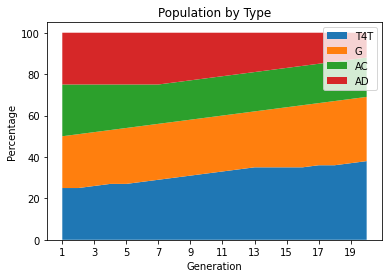

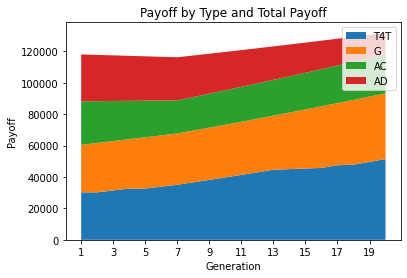

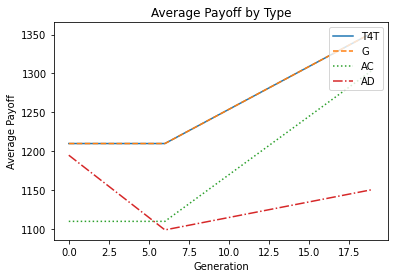

P value is: 4


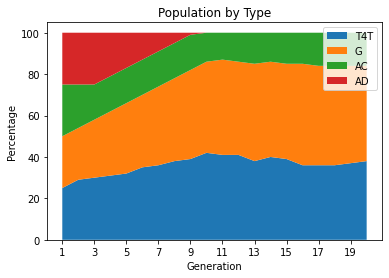

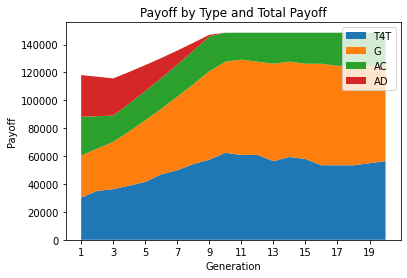

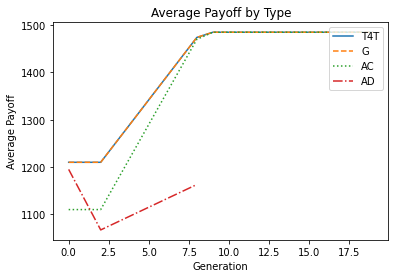

P value is: 7


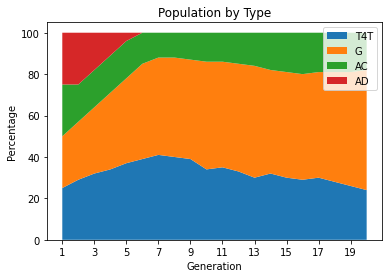

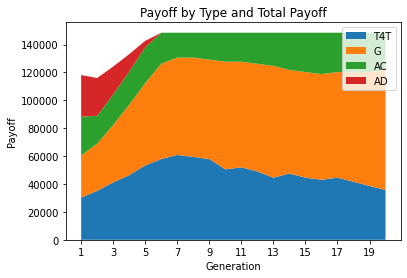

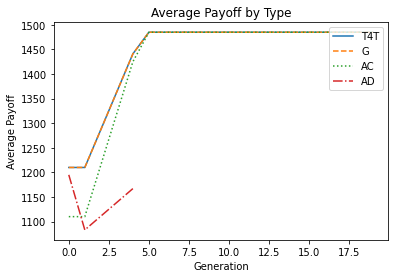

P value is: 10


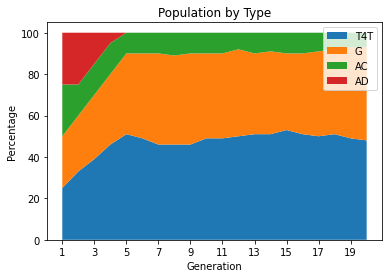

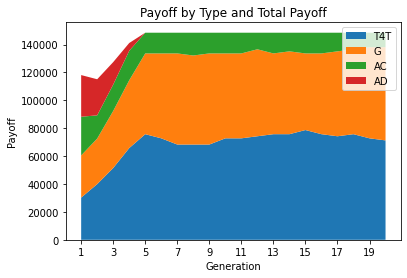

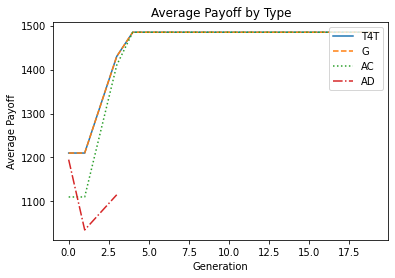

P value is: 13


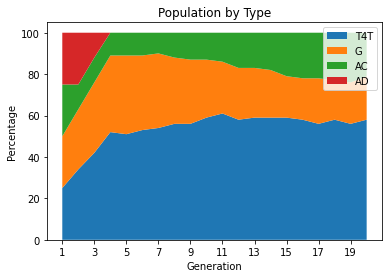

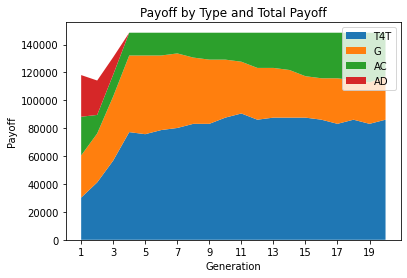

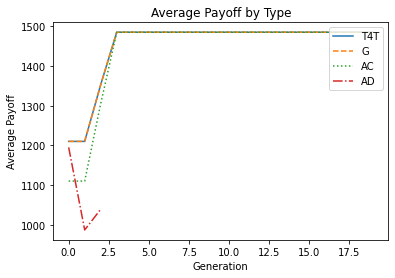

P value is: 16


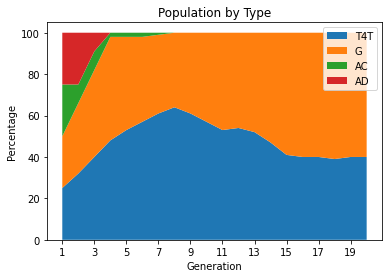

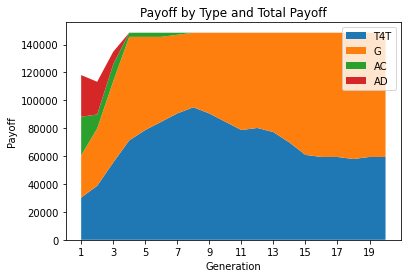

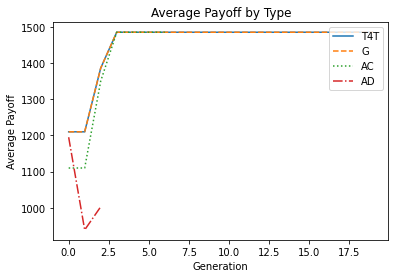

P value is: 19


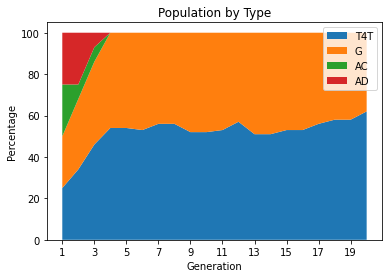

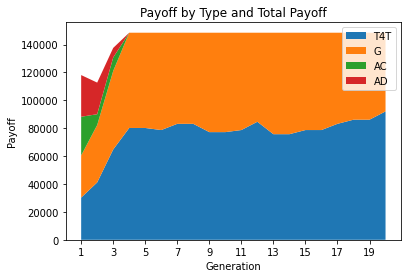

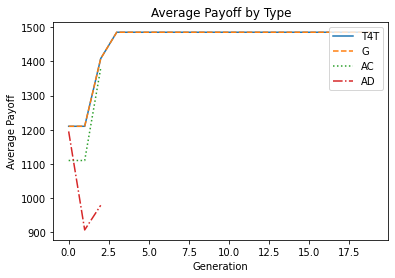

P value is: 22


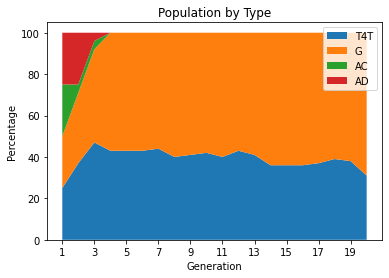

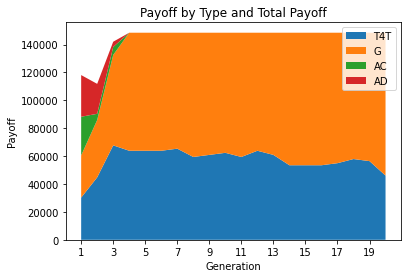

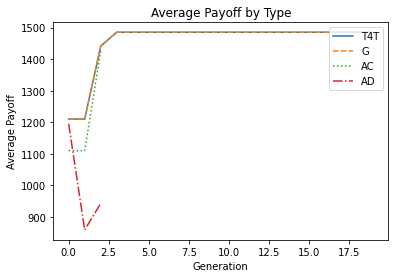

In [21]:
# Systematically varying value of p
# Running the program with specified parameters from Q1

n = 100 # Starting num of players
m = 5 # Rounds between players
p = 1 # Pruning between generations, will vary
k = 20 # Generations
for p in range(1, 25, 3):
    print("P-Val", p)
    players = gen_n_player_evenly(n)
    birth(players, m, p, k, printing=False)
    plot_globals()

JK GREEN DIES! AHH